In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
from tqdm import tqdm

from ExptTrace import ExptTrace
from misc import rcsetup

rcsetup()

sys.path.append("../")
from data import get_powerlaw
from utils import ensure_torch, ensure_numpy
from feature_decomp import generate_fra_monomials
from kernels import GaussianKernel, krr
from eigenlearning import eigenlearning
from tools import estimate_beta

In [35]:
M = 100_000         # function space dimension
n = 10_000           # number of samples
source_exp = 1.25

# random target function (components are function space coeffs)
# vstar \in R^M, ||vstar|| = 1
powerlaw = get_powerlaw(M, source_exp/2, offset=6)
vstar = ensure_torch(torch.normal(0, 1, (M,))) * powerlaw
vstar /= torch.linalg.norm(vstar)

# randomly sample vstar in data space (y_i = vstar(x_i))
# y \in R^n, y_i ~ O(1)
# tbh I should be adding y-noise to account for the missing tail, but whatever
H = ensure_torch(torch.normal(0, 1, (n, M)))
y = H @ vstar


In [36]:
# eigenlearning experiment
from kernels import LaplaceKernel

print("Constructing kernel")
data_dim = 200
data_eigval_exp = 3.0
data_eigvals = get_powerlaw(data_dim, data_eigval_exp, offset=6)
eval_level_coeff = GaussianKernel.get_level_coeff_fn(data_eigvals, kernel_width=10)
kernel_eigvals, _ = generate_fra_monomials(data_eigvals, M, eval_level_coeff)

K = (H * ensure_torch(kernel_eigvals).unsqueeze(0)) @ H.T

def get_ntrials(ntrain):
    if ntrain < 100: return 20
    elif ntrain < 1000: return 10
    elif ntrain < 10000: return 5
    else: return 2

ntest = 2_000
log_ntrain_max = np.log10((n - ntest)/1.1)
ntrains = np.unique(np.logspace(1, log_ntrain_max, base=10, num=20).astype(int))
ridge = 1e-3

var_axes = ["trial", "ntrain"]
et_yhat = ExptTrace(var_axes)

print("Beginning experiment")
for ntrain in tqdm(ntrains):
    for trial in range(get_ntrials(ntrain)):
        (y_hat, y_test), _ = krr(K, y, ntrain, n_test=ntest, ridge=ridge)
        et_yhat[trial, ntrain] = y_hat.cpu().numpy()


Constructing kernel


Generating monomials: 100%|██████████| 100000/100000 [00:11<00:00, 8981.64step/s]


Beginning experiment


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


In [43]:
import importlib
import tools
importlib.reload(tools)
from tools import estimate_beta

In [44]:
beta, coeff, mse_trials = estimate_beta(K, y, ntrains, n_test=ntest, n_tailstart=800)
print(beta, coeff)

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

1.1229248445402062 1.1042684209037383


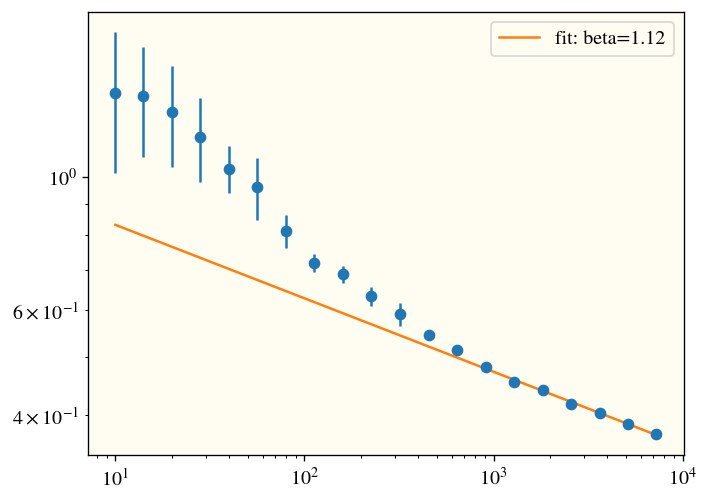

In [45]:
mse = mse_trials.mean(axis=0)
mse_std = mse_trials.std(axis=0)

plt.errorbar(ntrains, mse, yerr=mse_std, fmt='o')
plt.plot(ntrains, coeff * ntrains**(-beta+1), label=f"fit: beta={beta:.2f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [64]:
from tqdm import trange

def grf(H, y, P):
    if P is None:
        P = H.shape[1]
    assert P <= H.shape[1], "P must not exceed num modes"

    vhat = ensure_torch(torch.zeros(P))
    residual = y.clone()
    with trange(P, desc="GRF", unit="step", total=P) as pbar:
        for j in pbar:
            phi_j = H[:, j]
            vhat[j] = torch.dot(phi_j, residual) / torch.linalg.norm(phi_j) ** 2
            residual -= vhat[j] * phi_j
            pbar.set_postfix(uncaptured=residual.std().item())
    uncaptured = residual.std().item()
    return vhat, uncaptured



In [68]:
def get_coeff_stats(vstar, H, y, P=None, source_exp=None):
    if P is None:
        assert source_exp is not None
        P = int(n * (source_exp - 1) / source_exp)
    vhat = torch.linalg.lstsq(H[:, :P], y).solution
    uncaptured = (vstar[P:]**2).sum().item()
    # mse = ((vhat - vstar[:P])**2).sum().item() + uncaptured
    return vhat, uncaptured

def compute_learning_curve(ntrains, kernel_eigvals, coeffs, ridge, noise_var):
    kernel_eigvals, coeffs = ensure_numpy(kernel_eigvals), ensure_numpy(coeffs)
    lrn_curve = [
        eigenlearning(n, kernel_eigvals, coeffs, ridge=ridge, noise_var=noise_var)["test_mse"]
        for n in ntrains
    ]
    return np.array(lrn_curve)

yhat = et_yhat[:, :].squeeze()
ystar = ensure_numpy(y)[-ntest:]
mse = ((yhat - ystar)**2).mean(axis=-1)
mse_mean, mse_std = mse.mean(axis=0), mse.std(axis=0)

vhat_grf, uncaptured = grf(H, y, P=None)
noise_var = uncaptured / np.sqrt(n)
# get_coeff_stats(vstar, H, y, source_exp=source_exp)

GRF:   0%|          | 0/100000 [00:00<?, ?step/s, uncaptured=0.862]

GRF: 100%|██████████| 100000/100000 [01:34<00:00, 1058.46step/s, uncaptured=0.00229]


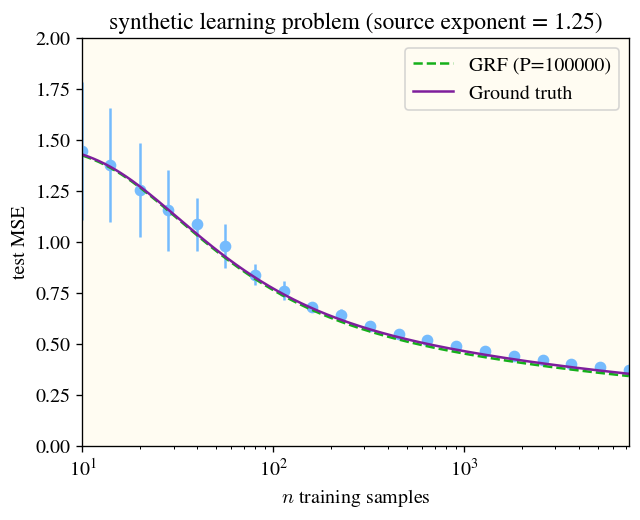

In [66]:
ntrains_dense = np.logspace(np.log10(ntrains[0]), np.log10(ntrains[-1]), 200)
lrn_curve_tru = compute_learning_curve(ntrains_dense, kernel_eigvals, vstar, ridge=ridge, noise_var=0)
lrn_curve_opt = compute_learning_curve(ntrains_dense, kernel_eigvals, vhat_grf, ridge=ridge, noise_var=noise_var)

fig, ax = plt.subplots(figsize=(5.5, 4.5))
colors = ['xkcd:bright blue', 'xkcd:aubergine', 'xkcd:pale red']
ax.errorbar(ntrains, mse_mean, yerr=mse_std, color='xkcd:sky blue',
            ls='none', marker='o', zorder=-4)

ax.plot(ntrains_dense, lrn_curve_opt, color='xkcd:green', ls="--", label=f"GRF (P={len(vhat_grf)})")
ax.plot(ntrains_dense, lrn_curve_tru, color='xkcd:purple', label="Ground truth")

ax.set_title(f"synthetic learning problem (source exponent = {source_exp})",
             fontsize=14)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")
ax.set_xlim(ntrains[0], ntrains[-1])
ax.set_ylim(0, 2)

ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def bayesian_estimate_vstar_diagonal(c_diag, H, y, noise_var=1e-12):
    c_diag, H, y = ensure_torch(c_diag), ensure_torch(H), ensure_torch(y)
    
    # posterior_precision_diag = 1/c_diag + (H^T H)_diag / noise_var
    HtH_diag = (H**2).sum(dim=0)  # diagonal of H^T H
    posterior_precision_diag = 1.0 / c_diag + HtH_diag / noise_var
    posterior_var_diag = 1.0 / posterior_precision_diag
    
    # posterior mean = posterior_var_diag * (H^T y) / noise_var
    vhat = posterior_var_diag * (H.T @ y) / (noise_var+1e-16)

    return vhat, posterior_var_diag

# Test the efficient diagonal version
print("Testing efficient diagonal Bayesian estimation...")

noise_var = 1e-4
C_prior = powerlaw**2
vhat_bayes_diag, posterior_var_diag = bayesian_estimate_vstar_diagonal(C_prior, H, y, noise_var=noise_var)

error_norm_bayes_diag = torch.linalg.norm(vhat_bayes_diag - vstar).item()
print(f"Diagonal Bayesian error norm: {error_norm_bayes_diag:.6f}")
error_norm_grf = torch.linalg.norm(vhat_grf - vstar).item()
print(f"Diagonal GRF error norm: {error_norm_grf:.6f}")

# Compare uncertainty estimates
print(f"Average posterior std (diagonal): {torch.sqrt(posterior_var_diag).mean():.4f}")
print(f"Average prior std: {torch.sqrt(C_prior).mean():.4f}")

Testing efficient diagonal Bayesian estimation...
Diagonal Bayesian error norm: 0.522743
Diagonal GRF error norm: 0.492637
Average posterior std (diagonal): 0.0000
Average prior std: 0.0000


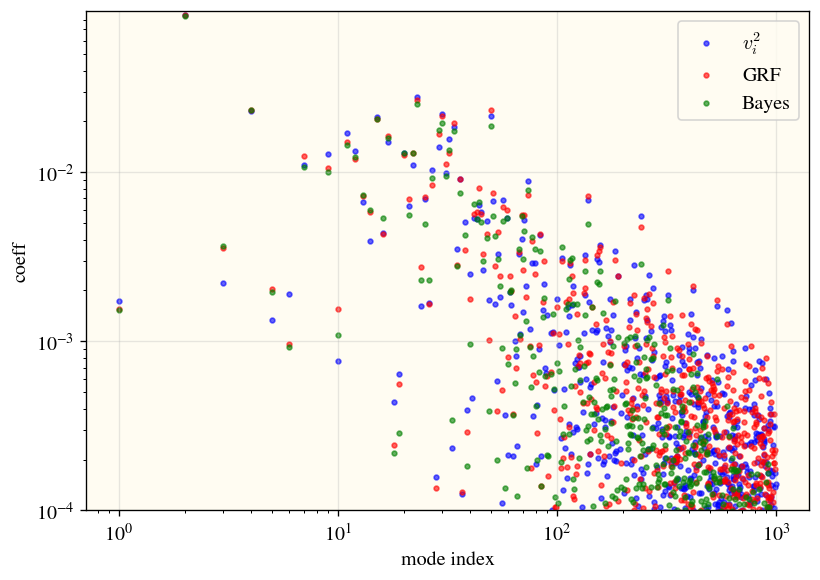


Recovery statistics:
Error norm (first 100 coeffs): 0.092813
Error norm (coeffs 100-1000): 0.253766
Error norm (coeffs 1000+): 0.447492


In [99]:
# Plot vstar and vhat as a function of coordinate index
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Choose number of coefficients to plot (subset for visibility)
n_plot = 1000
indices = np.arange(n_plot)

vhat_bayes_plot = vhat_bayes_diag[:n_plot].cpu().numpy()
vhat_grf_plot = vhat_grf[:n_plot].cpu().numpy()

# Right plot: log-scale version to better see the powerlaw decay
ax.scatter(1+indices, vstar[:n_plot].cpu().numpy()**2, alpha=0.6, s=8, label=f'$v_i^2$', color='blue')
ax.scatter(1+indices, vhat_grf_plot**2, alpha=0.6, s=8, label='GRF', color='red')
ax.scatter(1+indices, vhat_bayes_plot**2, alpha=0.6, s=8, label='Bayes', color='green')

ax.set_ylim(bottom=1e-4)

ax.set_xlabel('mode index')
ax.set_ylabel('coeff')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the recovery
print(f"\nRecovery statistics:")
print(f"Error norm (first 100 coeffs): {torch.linalg.norm(vhat_bayes_diag[:100] - vstar[:100]):.6f}")
print(f"Error norm (coeffs 100-1000): {torch.linalg.norm(vhat_bayes_diag[100:1000] - vstar[100:1000]):.6f}")
print(f"Error norm (coeffs 1000+): {torch.linalg.norm(vhat_bayes_diag[1000:] - vstar[1000:]):.6f}")